# HyperTune Prep

In [19]:
import numpy as np
from numpy.ma import MaskedArray
from sklearn import tree
import sklearn.utils.fixes
from skopt.space import Real, Integer, Categorical, Space
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
from numpy.random import randint
from time import time
# monkey patch to fix skopt and sklearn.  Requires downgrade to sklearn 0.23
from numpy.ma import MaskedArray
import sklearn.utils.fixes
sklearn.utils.fixes.MaskedArray = MaskedArray
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from time import sleep

import skopt
from skopt import BayesSearchCV
from skopt import callbacks

## Splitter

In [2]:
def split(df, test=0.2, val=0, scaler=None):
    scaler_method = None
    if scaler == "std":  # Determine data scaling method
        scaler_method = StandardScaler()
    elif scaler == "minmax":
        scaler_method = MinMaxScaler()

    target = np.array(df['price'])
    features = np.array(df.drop(['price'], axis=1))
    in_shape = features.shape[1]
    
    val_features = val_target = None
            
    if val == 0:
        train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=test,
                                                                                random_state=randint(low=1, high=50))
    else:
        train_features, val_features, train_target, val_target = train_test_split(train_features, train_target, test_size=val/(1-test),
                                                                                random_state=randint(low=1, high=50))
    if scaler_method is not None:
        train_features = scaler_method.fit_transform(train_features)
        test_features = scaler_method.transform(test_features)
        if val != 0:
            val_features = scaler_method.transform(val_features)
    
    print('Total Feature Shape:', features.shape)
    print('Total Target Shape', target.shape)
    print()
    print('Training Features Shape:', train_features.shape)
    print('Training Target Shape:', train_target.shape)
    print()
    print('Test Features Shape:', test_features.shape)
    print('Test Target Shape:', test_target.shape)
    print()
    
    return train_features, test_features, train_target, test_target, val_features, val_target, in_shape


## Grid

In [3]:
def gdb_bayes_grid():
    """ Defines hyper parameters for gradient decent boost """

    # Number of trees
    n_estimators = [int(x) for x in np.linspace(start=500, stop=2000, num=20)]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 25, num=24, endpoint=True)]

    # Minimum number of samples required to split a node
    min_samples_split = [int(x) for x in np.linspace(2, 30, num=10, endpoint=True)]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [int(x) for x in np.linspace(2, 30, num=10, endpoint=True)]

    # learning rate
    learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

    param_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'learning_rate': learning_rate
    }
#     return param_grid
    bayes_grid = {
        'n_estimators': Integer(500, 2000),
        'max_features': Categorical(['auto', 'sqrt']),
        'max_depth': Integer(1, 25),
        'min_samples_split': Integer(2, 30),
        'min_samples_leaf': Integer(2, 30),
        'learning_rate': Real(0.01, 1, 'log-uniform')
    }
    return param_grid


def keras_bayes_grid():
     # Number of hidden nodes
    n_hidden = [int(x) for x in np.linspace(start=1, stop=30, num=30)]

    # Number of neurons
    n_neuron = [int(x) for x in np.linspace(start=50, stop=300, num=50)]

    # Learning rate
    learning_rate = [float(x) for x in np.linspace(start=0.0001, stop=0.1, num=50)]

    # Drop out rate
    drop = [float(x) for x in np.linspace(start=0.1, stop=0.5, num=10)]

    param_grid = {
        'n_hidden': n_hidden,
        "n_neuron": n_neuron,
        'learning_rate': learning_rate,
        'drop': drop
    }
    return param_grid


def make_grid(algorithm):
    """ Dictionary containing all the grid functions. Can call specific function based off of dict key."""
#     gdb_grid = gdb_bayes_grid()
#     keras_grid = keras_bayes_grid()
    grids = {
        'nn': keras_bayes_grid,
        'gdb': gdb_bayes_grid

    }

#     param_grid = 
    return grids[algorithm]()

## HyperTune

In [4]:
from tensorflow import keras
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.metrics import RootMeanSquaredError


### Build NN

In [5]:
def build_nn(n_hidden=2, n_neuron=50, learning_rate=1e-3, in_shape=200, drop=0.1):
    """
    Create neural network architecture and compile.  Accepts number of hiiden layers, number of neurons,
    learning rate, and input shape. Returns compiled model.

    Keyword Arguments:
        n_hidden (integer): Number of hidden layers added to model, excludes input and output layer. Default = 2
        n_neuron (integer): Number of neurons to add to each hidden layer. Default = 50
        learning_rate (float):  Model learning rate that is passed to model optimizer.
                                Smaller values are slower, High values are prone to unstable training. Default = 0.001
        in_shape (integer): Input dimension should match number of features.  Default = 200 but should be overridden.
        drop (float): Dropout probability.  1 means drop everything, 0 means drop nothing. Default = 0.
                        Recommended = 0.2-0.6
    """

    model = keras.models.Sequential()
    # use dropout layer as input.
    model.add(keras.layers.Dropout(drop, input_shape=(in_shape,)))  # in_shape should be iterable (tuple)
    # model.add(keras.layers.InputLayer(input_shape=in_shape))  # input layer.  How to handle shape?
    for layer in range(n_hidden):  # create hidden layers
        model.add(keras.layers.Dense(n_neuron, activation="relu"))
        model.add(keras.layers.Dropout(drop))  # add dropout to model after the a dense layer

    model.add(keras.layers.Dense(1))  # output layer
    # TODO Add optimizer selection as keyword arg for tuning
    # optimizer = keras.optimizers.SGD(lr=learning_rate)  # this is a point to vary.  Dict could help call other ones.
    # optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError(name='rmse')])

    return model

### Wrap Keras into Sklearn Regressor

In [6]:
def wrapKeras(build_func, in_shape, tuned=False):
    """
    Wraps up a Keras model to appear as sklearn Regressor for use in hyper parameter tuning.
    :param self: For use in MLmodel class instance.
    :param build_func: Callable function that builds Keras model.
    :return: Regressor() like function for use with sklearn based optimization.
    """

    # pass non-hyper params here
    # if model has been tuned, it should have 'parrams' attribute
    # create regressor instance with tuned parameters
    # if self.algorithm == 'nn':
    if tuned:
            estimator = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_func, in_shape=in_shape, **params)
    # has not been tuned and no params have been supplied, so use default.
    else:
            estimator = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_func, in_shape=in_shape)
    return estimator

### Implement tqdm Progress Bar

In [7]:
from tqdm import tqdm
# for making a progress bar for skopt
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

### Keras Early Stopping Call Backs and Scoring Function

In [8]:
stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# fit_params = {'epochs': 100, 'batch_size': 32, 'callbacks': [stop_cb], 'validation_data': (val_features, val_target)}
scoring = 'neg_mean_squared_error'

### Get Estimator

In [9]:
def get_regressor(algorithm, in_shape=None, given_param=None, val_features=None, val_target=None, call=False):
    """
    Returns model specific regressor function.
    Optional argument to create callable or instantiated instance.
    """
    
    if algorithm  == 'nn':  # neural network

        stop_cb = keras.callbacks.EarlyStopping(patience=10,  # number of epochs to wait for progress
                                                restore_best_weights=True)

        # params to pass to Keras fit method that don't match sklearn params
        fit_params = {'epochs': 100,
                           'batch_size': 32,
                           'callbacks': [stop_cb],
                           'validation_data': (val_features, val_target)
                           }
        # wrap regressor like a sklearn regressor
        estimator = wrapKeras(build_func=build_nn, in_shape=in_shape)

    else:
        if given_param is not None:
            estimator = GradientBoostingRegressor(**given_param)
        else:
            estimator = GradientBoostingRegressor()


    return estimator
    

### HyperTune Estimator

In [10]:
def hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring, deltay=None,fit_params=None):
    tune_algorithm = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_grid,
            n_iter=opt_iter,  # number of combos tried
            scoring=scoring,
            random_state=42,
            n_jobs=n_jobs,
            cv=cv_folds

        )
#     tune_algorithm = BayesSearchCV(
#             estimator=estimator,
#             search_spaces=param_grid,
#             fit_params=fit_params,
#             n_iter=opt_iter,  # number of combos tried
#             scoring=scoring,
#             verbose=3,
#             random_state=42,
#             n_jobs=n_jobs,
#             cv=cv_folds

#         )

    tune_algorithm.fit(train_features, train_target)
     # collect best parameters from tuning
    params = tune_algorithm.best_params_
    tune_score = tune_algorithm.best_score_
#     estimator = GradientBoostingRegressor(**params) 
    
    return params, tune_score

    

### Train Regressors

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

def train_reg(estimator,train_features, train_target, test_features, test_target,n=5):
    """
    Function to train the model n times and collect basic statistics about results.
    :param self:
    :param n: number of replicates
    :return:
    """

    print("Starting model training with {} replicates.\n".format(n), end=' ', flush=True)

    # empty arrays for storing replicated data
    r2 = np.empty(n)
    mse = np.empty(n)
    rmse = np.empty(n)
    t = np.empty(n)

    pva_multi = pd.DataFrame([])
    pva_multi['actual'] = test_target

    for i in tqdm(range(0, n), desc="Model Replication\n"):  # run model n times
        start_time = time()
        estimator.fit(train_features, train_target)

        # Make predictions
        predictions = estimator.predict(test_features)
        done_time = time()
        fit_time = done_time - start_time

        # Dataframe for replicate_model
        pva = pd.DataFrame([], columns=['actual', 'predicted'])
        pva['actual'] = test_target
        pva['predicted'] = predictions
        r2[i] = r2_score(pva['actual'], pva['predicted'])
        mse[i] = mean_squared_error(pva['actual'], pva['predicted'])
        rmse[i] = np.sqrt(mean_squared_error(pva['actual'], pva['predicted']))
        t[i] = fit_time
        # store as enumerated column for multipredict
        pva_multi['predicted' + str(i)] = predictions
        sleep(0.25)  # so progress bar can update
    print('Done after {:.1f} seconds.'.format(t.sum()))

    # Store predicted columns and calculate predicted_average and predicted_std
    predicted_columns = pva_multi.columns.difference(['actual'])
    pva_multi_scaled = pva_multi
                                                      
    # Holding variables for scaled data
    scaled_r2 = np.empty(n)
    scaled_mse = np.empty(n)
    scaled_rmse = np.empty(n)

    # Drop smiles (and save them) then calculate max/min values of entire predicted dataframe
#     smiles = pva_multi['smiles']
#     pva_multi_scaled = pva_multi.drop('smiles', axis=1)
    data_max = max(pva_multi_scaled.max())  # Find abs min/max of predicted data
    data_min = min(pva_multi_scaled.min())

    # Logic to scale the predicted data, using min/max scaling
    pva_multi_scaled = (pva_multi_scaled - data_min) / (data_max - data_min)

    # Calculate r2, rmse, mse or for each pva columns
    for i, predicted_column in enumerate(predicted_columns):
        scaled_r2[i] = r2_score(pva_multi_scaled['actual'], pva_multi_scaled[predicted_column])
        scaled_mse[i] = mean_squared_error(pva_multi_scaled['actual'], pva_multi_scaled[predicted_column])
        scaled_rmse[i] = np.sqrt(scaled_mse[i])

    # Tack on smiles
#     pva_multi_scaled['smiles'] = smiles

    # Will gather MSE, RMSE, and STD for each molecule in the predictions and scaled_predictions csv files
    def __gather_column_stats__(pva_df):
        pva_df['pred_avg'] = pva_df[predicted_columns].mean(axis=1)
        pva_df['pred_std'] = pva_df[predicted_columns].std(axis=1)
        pva_df['pred_average_error'] = abs(pva_df['actual'] - pva_df['pred_avg'])
        return pva_df

    pva_multi_scaled = __gather_column_stats__(pva_multi_scaled)
    pva_multi = __gather_column_stats__(pva_multi)

    stats = {
        'r2_raw': r2,
        'r2_avg': r2.mean(),
        'r2_std': r2.std(),
        'mse_raw': mse,
        'mse_avg': mse.mean(),
        'mse_std': mse.std(),
        'rmse_raw': rmse,
        'rmse_avg': rmse.mean(),
        'rmse_std': rmse.std(),
        'time_raw': t,
        'time_avg': t.mean(),
        'time_std': t.std()
    }

    scaled_stats = {
        'r2_raw_scaled': scaled_r2,
        'r2_avg_scaled': scaled_r2.mean(),
        'r2_std_scaled': scaled_r2.std(),
        'mse_raw_scaled': scaled_mse,
        'mse_avg_scaled': scaled_mse.mean(),
        'mse_std_scaled': scaled_mse.std(),
        'rmse_raw_scaled': scaled_rmse,
        'rmse_avg_scaled': scaled_rmse.mean(),
        'rmse_std_scaled': scaled_rmse.std(),
    }

    predictions = pva_multi
    predictions_stats = stats

    scaled_predictions = pva_multi_scaled
    scaled_predictions_stats = scaled_stats
    
    return predictions, predictions_stats, scaled_predictions, scaled_predictions_stats

### Predicted vs Actual Plotting

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm

def pva_graph(predictions, run_name, use_scaled=False):
    """
    Make Predicted vs. Actual graph with prediction uncertainty.
    Pass dataframe from multipredict function. Return a graph.
    """
    # Reuse function for scaled data
#     if use_scaled:
#         pva = scaled_predictions
#     else:
    pva = predictions

    r2 = r2_score(pva['actual'], pva['pred_avg'])
    mse = mean_squared_error(pva['actual'], pva['pred_avg'])
    rmse = np.sqrt(mean_squared_error(pva['actual'], pva['pred_avg']))

    plt.rcParams['figure.figsize'] = [12, 9]
    plt.style.use('bmh')
    fig, ax = plt.subplots()
    norm = cm.colors.Normalize(vmax=pva['pred_std'].max(), vmin=pva['pred_std'].min())
    x = pva['actual']
    y = pva['pred_avg']
    plt.scatter(x, y, c=pva['pred_std'], cmap='plasma', norm=norm, alpha=0.7)
    cbar = plt.colorbar()
    cbar.set_label("Uncertainty")

    # set axis limits
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])
            ]

    # ax = plt.axes()
    plt.xlabel('True', fontsize=14)
    plt.ylabel('Predicted', fontsize=14)
#     if use_scaled:
#         plt.title(run_name + f' Predicted vs. Actual (scaled)')
#     else:
#         plt.title(run_name + f' Predicted vs. Actual')

    plt.plot(lims, lims, 'k-', label='y=x')
    plt.plot([], [], ' ', label='R^2 = %.3f' % r2)
    plt.plot([], [], ' ', label='RMSE = %.3f' % rmse)
    plt.plot([], [], ' ', label='MSE = %.3f' % mse)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    # plt.axis([-2,5,-2,5]) #[-2,5,-2,5]
    ax.legend(prop={'size': 16}, facecolor='w', edgecolor='k', shadow=True)

    fig.patch.set_facecolor('blue')  # Will change background color
    fig.patch.set_alpha(0.0)  # Makes background transparent

    if use_scaled:
        plt.savefig(run_name+'_' + f'PVA_scaled.png')
    else:
        plt.savefig(run_name + '_' + f'PVA.png')
    

### Variable Importance for Tree Based Regressors

In [13]:
def impgraph(estimator, feature_list,run_name):
    """
    Objective: Make a feature importance graph. I'm limiting this to only rf and gdb since only they have feature
    importance (I might need to double check on that). I'm also limiting this to only rdkit2d since the rest are only 0s
    and 1s
    """

    # Get numerical feature importances

    importances2 = estimator.feature_importances_  # used later for graph


    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in
                               zip(feature_list, list(importances2))]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
#     if len(feature_importances) > 100:
#         feature_importances = feature_importances[:30]
    # Print out the feature and importances
    # [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

    # prepare importance data for export and graphing
    indicies = (-importances2).argsort()
    varimp = pd.DataFrame([], columns=['variable', 'importance'])
    varimp['variable'] = [feature_list[i] for i in indicies]
    varimp['importance'] = importances2[indicies]
    # Importance Bar Graph
    plt.rcParams['figure.figsize'] = [15, 9]

    # Set the style
    plt.style.use('bmh')
    varimp = varimp.head(30)
    # intiate plot (mwahaha)
    fig, ax = plt.subplots()
    plt.bar(varimp.index, varimp['importance'], orientation='vertical')

    # Tick labels for x axis
    plt.xticks(varimp.index, varimp['variable'], rotation='vertical')

    # Axis labels and title
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title(run_name + ' Variable Importances')

    # ax = plt.axes()
    ax.xaxis.grid(False)  # remove just xaxis grid

    plt.savefig(run_name + '_importance-graph.png')
#     plt.close()
    # self.impgraph = plt
    varimp = varimp

# Running HyperTune

## Price Model using Rdkit

In [110]:
manufacturer_norm_price = "hyper_tune_manufacterer.csv"
rdkit = "hyper_tune_non_norm_rdkit.csv"
rdkit_norm_price = "hyper_tune_norm_price.csv"

In [15]:
df_manufacturer = pd.read_csv(rdkit)
df_manufacturer.drop(['Unnamed: 0'], axis=1, inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')
df_manufacturer

,price,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,...,fr_priamide,fr_imidazole,fr_N_O,fr_imide,fr_sulfone,fr_SH,fr_thiocyan,fr_nitroso,pack,oz
0,6.520,279,40,98,9,9,5,1,6,84,...,0,0,0,0,0,0,0,0,3,5.4
1,3.960,83,16,36,1,1,1,0,1,30,...,0,0,0,0,0,0,0,0,3,6.0
2,5.920,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,3.4
3,4.960,285,56,120,12,12,1,0,1,107,...,0,0,0,0,0,0,0,0,2,4.8
4,5.470,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,3.960,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4.2
586,3.290,73,22,30,0,0,0,0,0,23,...,0,0,0,0,0,0,0,0,1,4.2
587,15.475,143,23,45,2,3,5,0,5,42,...,0,0,0,0,0,0,0,0,2,4.7
588,8.990,118,17,46,1,1,1,0,1,37,...,0,0,0,0,0,0,0,0,1,4.0


In [16]:
def col_to_int(df, column):
    for col in column:
        df[col] = [int(i) for i in list(df[col])]
    return df

### Non Scaled


In [17]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer)
train_features

Total Feature Shape: (590, 82)
Total Target Shape (590,)

Training Features Shape: (472, 82)
Training Target Shape: (472,)

Test Features Shape: (118, 82)
Test Target Shape: (118,)



array([[279.  ,  40.  ,  98.  , ...,   0.  ,   3.  ,   5.4 ],
       [161.  ,  26.  ,  61.  , ...,   0.  ,   2.  ,   4.1 ],
       [120.  ,  31.  ,  51.  , ...,   0.  ,   1.  ,   2.  ],
       ...,
       [ 83.  ,  19.  ,  32.  , ...,   0.  ,   1.  ,   1.5 ],
       [199.  ,  24.  ,  75.  , ...,   0.  ,   1.  ,   6.25],
       [  3.  ,   0.  ,   0.  , ...,   0.  ,   4.  ,   6.4 ]])

In [30]:
param_grid = make_grid('gdb')
# param_grid

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

estimator = GradientBoostingRegressor()


In [32]:
opt_iter = 50
cv_folds = 3
n_jobs = 3

In [21]:
cp_delta = float((0.05 - train_target.min())/(train_target.max() - train_target.min()))  # Min max scaling
cp_n_best = 5
deltay = callbacks.DeltaYStopper(cp_delta, cp_n_best)

In [22]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [23]:
estimator = get_regressor('gdb', given_param=params)

In [24]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:05<00:20,  5.11s/it]
Model Replication███████████████▌                                      | 2/5 [00:10<00:16,  5.39s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:15<00:10,  5.21s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:21<00:05,  5.51s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.42s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.39s/it]

Done after 25.6 seconds.


In [25]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "rdkit_non_norm_price_" + date_string

### Graph

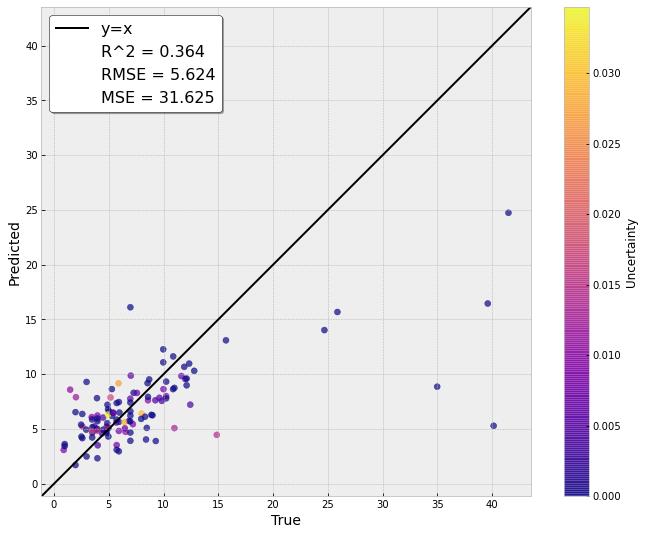

In [26]:
pva_graph(predictions, run_name, use_scaled=False)

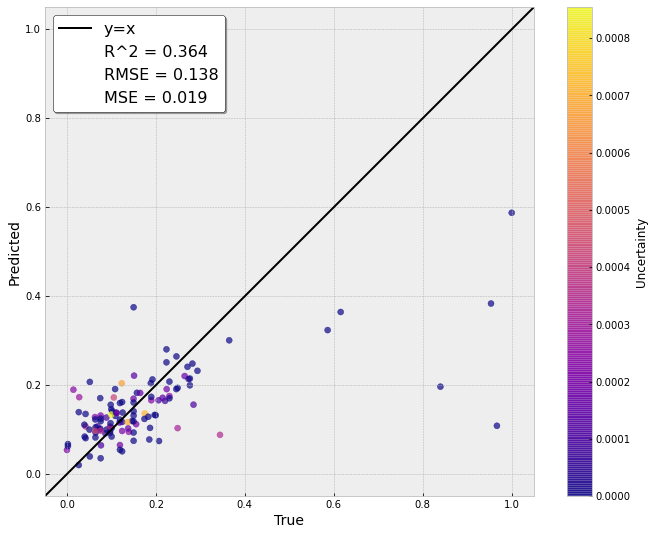

In [27]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

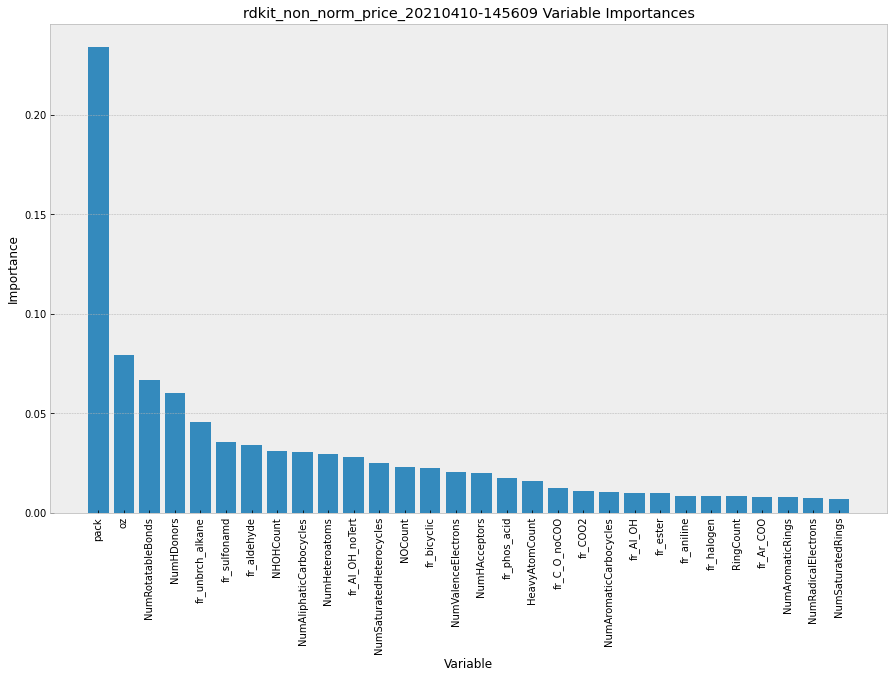

In [28]:
impgraph(estimator, feature_list, run_name)

### Scaled

In [29]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer, scaler='std')


Total Feature Shape: (590, 82)
Total Target Shape (590,)

Training Features Shape: (472, 82)
Training Target Shape: (472,)

Test Features Shape: (118, 82)
Test Target Shape: (118,)



In [30]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)
estimator = get_regressor('gdb', given_param=params)

In [31]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:06<00:27,  6.82s/it]
Model Replication███████████████▌                                      | 2/5 [00:15<00:24,  8.15s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:22<00:14,  7.34s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:30<00:07,  7.52s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.26s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.38s/it]

Done after 35.4 seconds.


In [32]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "rdkit_non_norm_price_scaled_" + date_string

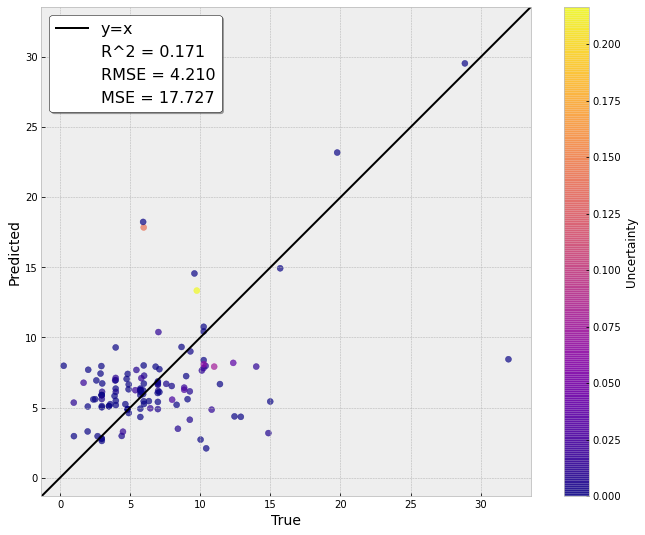

In [33]:
pva_graph(predictions, run_name, use_scaled=False)

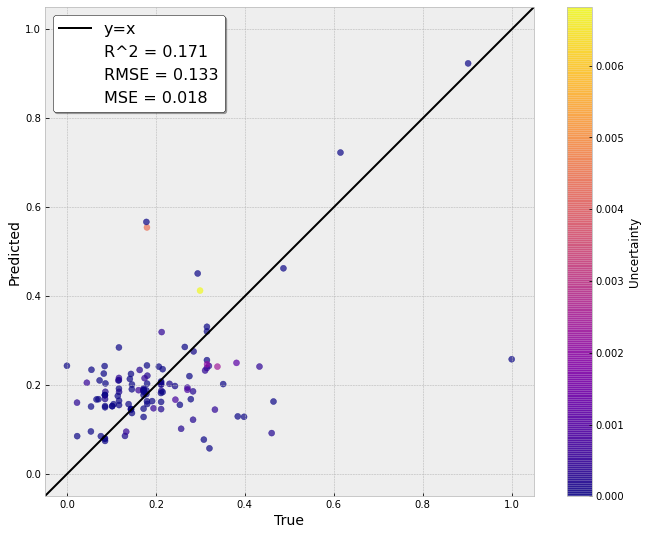

In [34]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

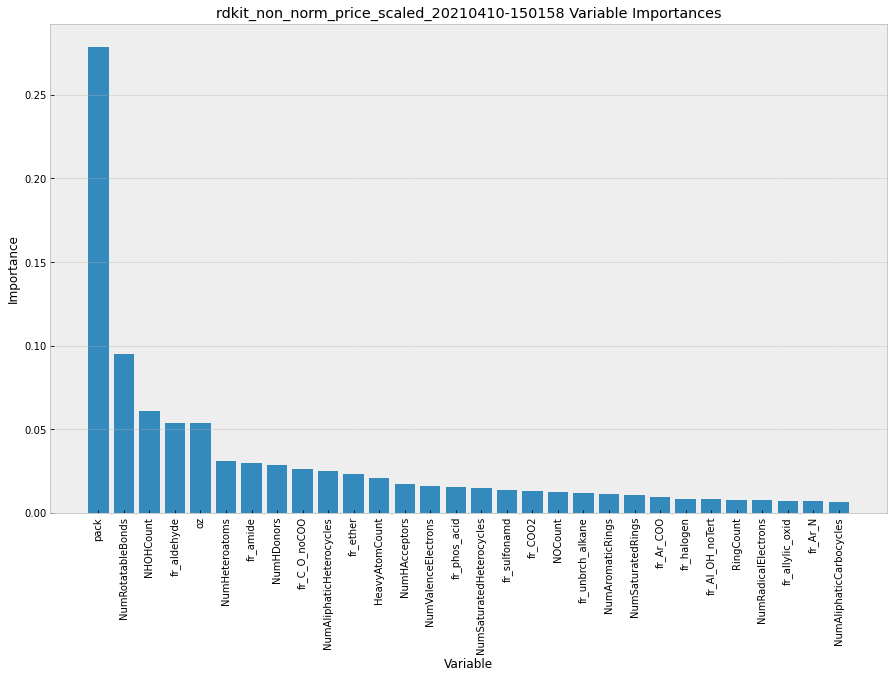

In [35]:
impgraph(estimator, feature_list, run_name)

## Price/Pack Using RDKIT

In [139]:
df_manufacturer = pd.read_csv(rdkit_norm_price)
df_manufacturer.drop(['Unnamed: 0', 'manufacturer'], axis=1, inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')
df_manufacturer.head(5)

,price,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,...,fr_priamide,fr_imidazole,fr_N_O,fr_imide,fr_sulfone,fr_SH,fr_thiocyan,fr_nitroso,pack,oz
0,2.17,279,40,98,9,9,5,1,6,84,...,0,0,0,0,0,0,0,0,3,5.4
1,1.32,83,16,36,1,1,1,0,1,30,...,0,0,0,0,0,0,0,0,3,6.0
2,5.92,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,3.4
3,2.48,285,56,120,12,12,1,0,1,107,...,0,0,0,0,0,0,0,0,2,4.8
4,5.47,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,3.4


### Non Scaled


In [140]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer)


Total Feature Shape: (590, 82)
Total Target Shape (590,)

Training Features Shape: (472, 82)
Training Target Shape: (472,)

Test Features Shape: (118, 82)
Test Target Shape: (118,)



In [141]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [142]:
estimator = get_regressor('gdb', given_param=params)

In [143]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:08<00:33,  8.35s/it]
Model Replication███████████████▌                                      | 2/5 [00:16<00:24,  8.32s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:24<00:16,  8.05s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:31<00:07,  7.88s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.87s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.97s/it]

Done after 38.5 seconds.


In [144]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "rdkit_norm_price_" + date_string

### Graph

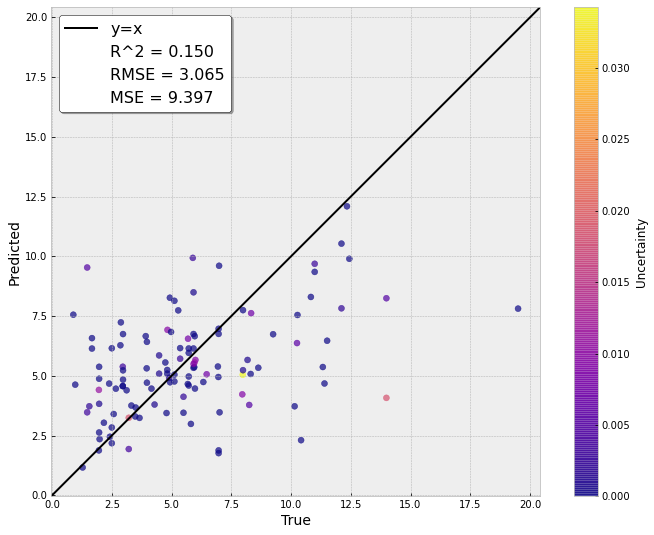

In [145]:
pva_graph(predictions, run_name, use_scaled=False)

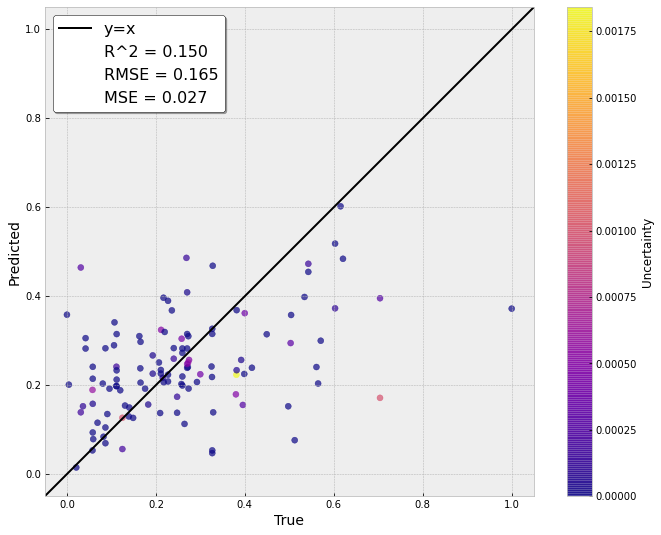

In [146]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

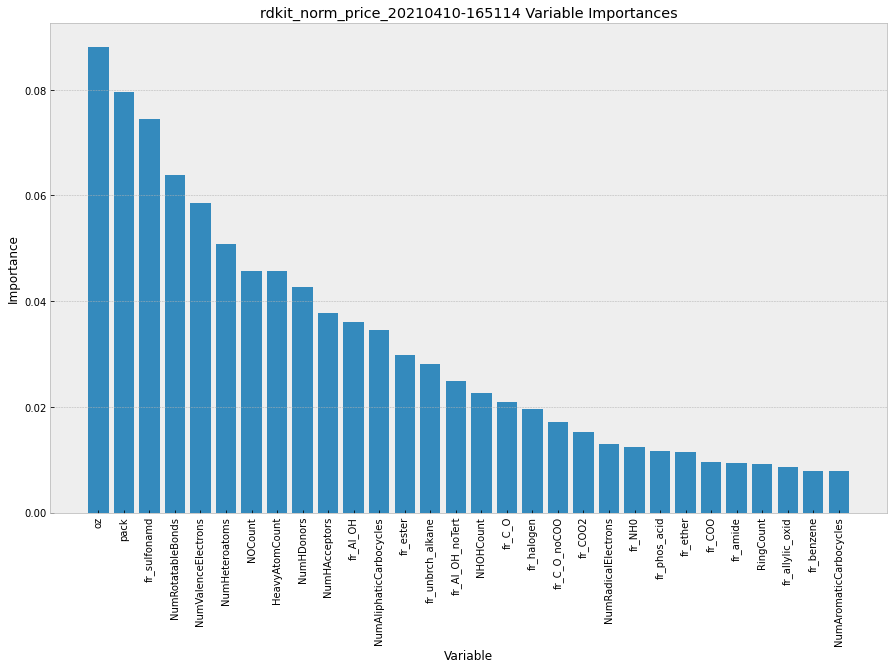

In [147]:
impgraph(estimator, feature_list, run_name)

### Scaled

In [148]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer, scaler='std')


Total Feature Shape: (590, 82)
Total Target Shape (590,)

Training Features Shape: (472, 82)
Training Target Shape: (472,)

Test Features Shape: (118, 82)
Test Target Shape: (118,)



In [149]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)
estimator = get_regressor('gdb', given_param=params)

In [150]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:00<00:02,  1.33it/s]
Model Replication███████████████▌                                      | 2/5 [00:01<00:02,  1.33it/s]
Model Replication████████████████████████████▍                         | 3/5 [00:02<00:01,  1.26it/s]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:03<00:01,  1.04s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]

Done after 3.5 seconds.


In [151]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "rdkit_norm_price_scaled_" + date_string

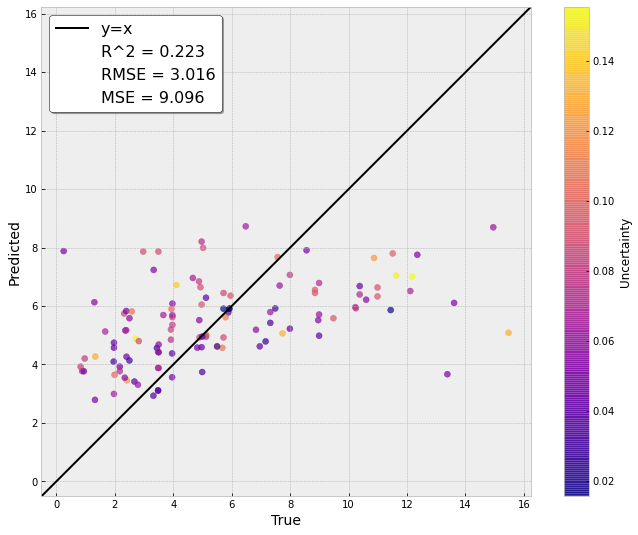

In [152]:
pva_graph(predictions, run_name, use_scaled=False)

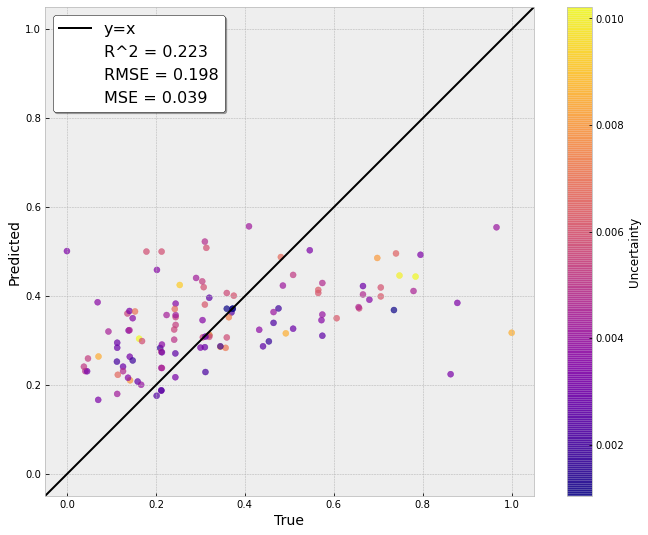

In [153]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

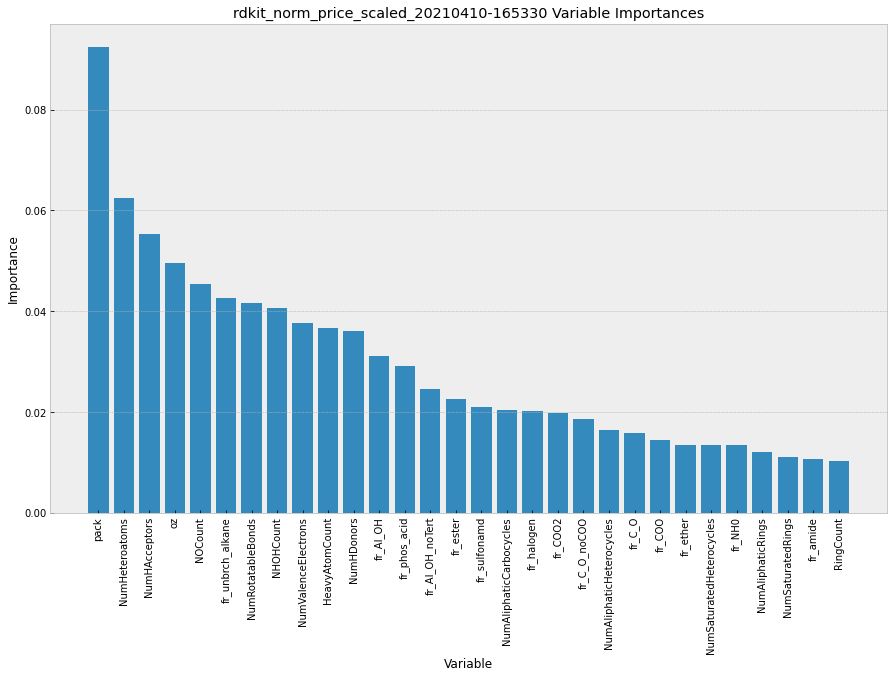

In [154]:
impgraph(estimator, feature_list, run_name)

## Price/Pack Model Manufacturer 

In [1]:
df_manufacturer = pd.read_csv(manufacturer_norm_price)
df_manufacturer.drop(['Unnamed: 0', 'product_id'], axis=1, inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')
df_manufacturer.head(5)

NameError: name 'pd' is not defined

In [53]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer)


Total Feature Shape: (540, 676)
Total Target Shape (540,)

Training Features Shape: (432, 676)
Training Target Shape: (432,)

Test Features Shape: (108, 676)
Test Target Shape: (108,)



In [54]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [55]:
estimator = get_regressor('gdb', given_param=params)

In [56]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:01<00:05,  1.38s/it]
Model Replication███████████████▌                                      | 2/5 [00:02<00:04,  1.42s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:04<00:03,  1.54s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:05<00:01,  1.49s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.49s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]

Done after 6.1 seconds.


In [57]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_" + date_string

### Graph

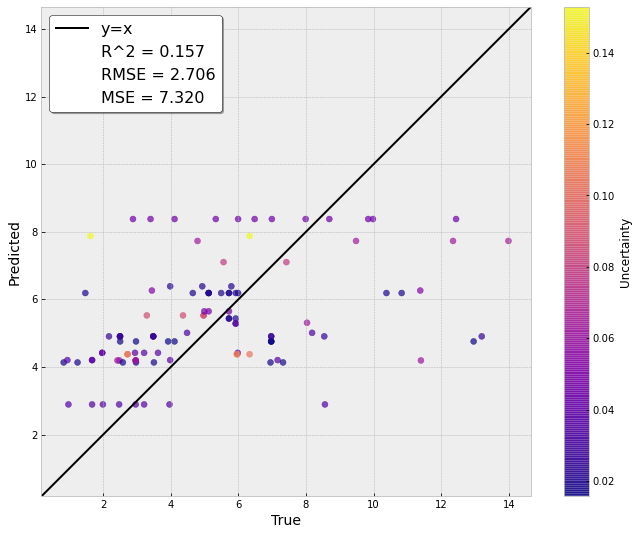

In [58]:
pva_graph(predictions, run_name, use_scaled=False)

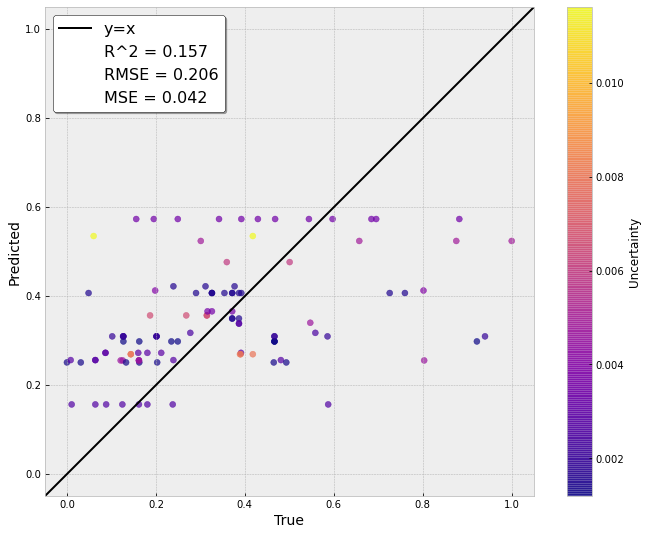

In [59]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

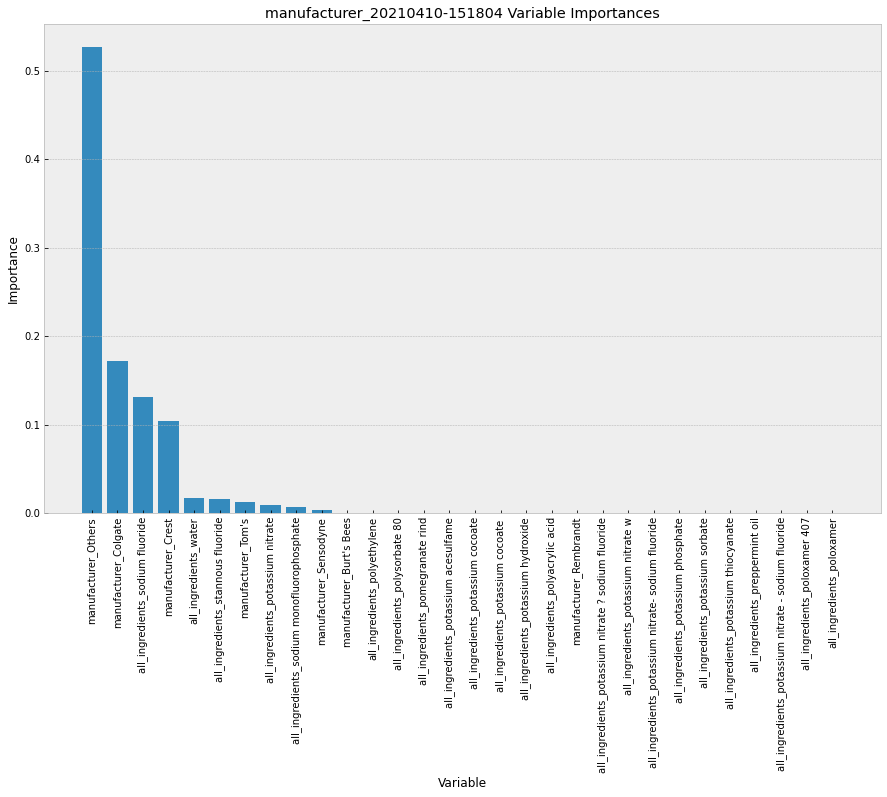

In [60]:
impgraph(estimator, feature_list, run_name)

## Price/Pack Manufacturer + Rdkit

In [121]:
df_rdkit_norm = pd.read_csv(rdkit_norm_price)
df_rdkit_norm.drop(['Unnamed: 0'], axis=1, inplace=True)

df_rdkit_norm.head(5)

,price,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,...,fr_imidazole,fr_N_O,fr_imide,fr_sulfone,fr_SH,fr_thiocyan,fr_nitroso,pack,oz,manufacturer
0,2.17,279,40,98,9,9,5,1,6,84,...,0,0,0,0,0,0,0,3,5.4,Crest
1,1.32,83,16,36,1,1,1,0,1,30,...,0,0,0,0,0,0,0,3,6.0,Colgate
2,5.92,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,1,3.4,Parodontax
3,2.48,285,56,120,12,12,1,0,1,107,...,0,0,0,0,0,0,0,2,4.8,Colgate
4,5.47,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,1,3.4,Parodontax


In [122]:
df_manufacturer = pd.read_csv(manufacturer_norm_price)
df_manufacturer = df_manufacturer.merge(df_rdkit_norm, how='right', on='price')
df_manufacturer.drop_duplicates(subset=['product_id'], inplace=True)
df_manufacturer.drop(['Unnamed: 0', 'product_id', 'manufacturer'], inplace=True, axis=1)
df_manufacturer.dropna(inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')

### Non Scaled

In [123]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer)


Total Feature Shape: (540, 758)
Total Target Shape (540,)

Training Features Shape: (432, 758)
Training Target Shape: (432,)

Test Features Shape: (108, 758)
Test Target Shape: (108,)



In [124]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [125]:
estimator = get_regressor('gdb', given_param=params)

In [126]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:15<01:03, 15.80s/it]
Model Replication███████████████▌                                      | 2/5 [00:29<00:43, 14.46s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:44<00:29, 14.67s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:59<00:14, 14.99s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.94s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.91s/it]

Done after 73.2 seconds.


In [127]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_rdkit_norm_price_" + date_string

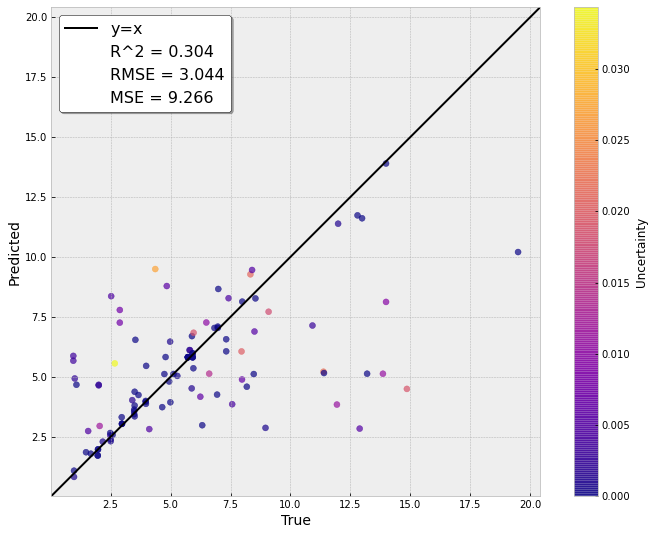

In [128]:
pva_graph(predictions, run_name, use_scaled=False)

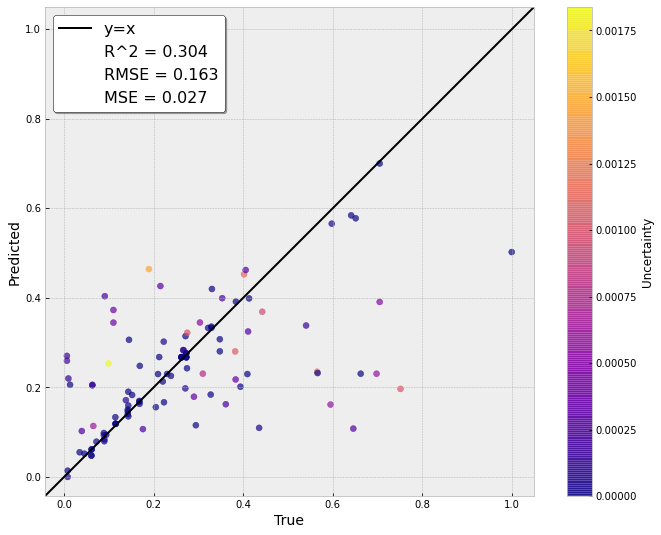

In [129]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

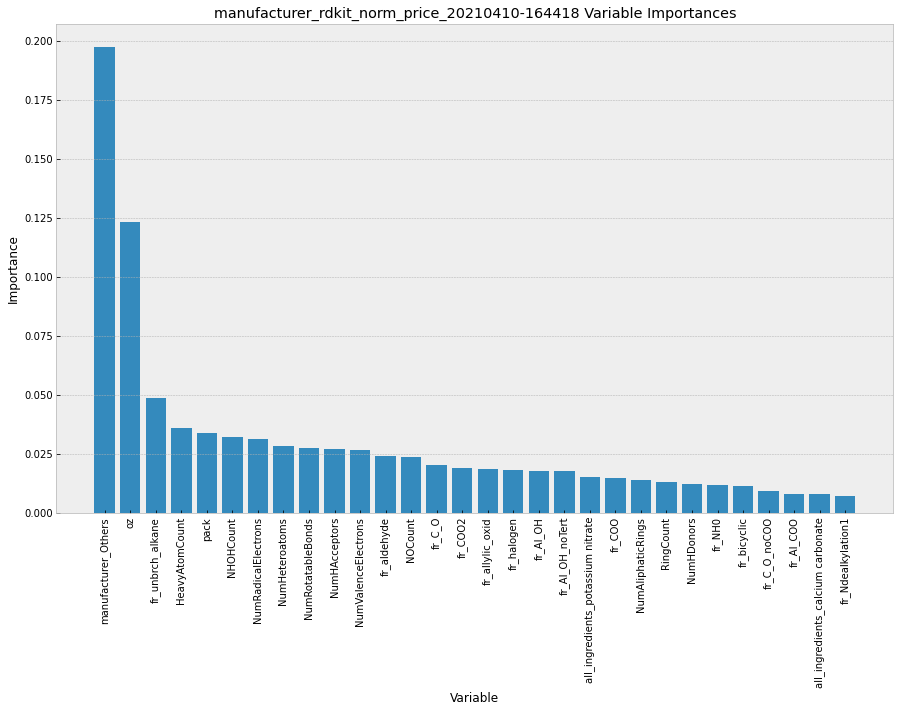

In [130]:
impgraph(estimator,feature_list, run_name)

### Scaled

In [131]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer, scaler='std')


Total Feature Shape: (540, 758)
Total Target Shape (540,)

Training Features Shape: (432, 758)
Training Target Shape: (432,)

Test Features Shape: (108, 758)
Test Target Shape: (108,)



In [132]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [29]:
estimator = get_regressor('gdb', given_param=params)

NameError: name 'params' is not defined

In [134]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:01<00:06,  1.67s/it]
Model Replication███████████████▌                                      | 2/5 [00:03<00:05,  1.69s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:05<00:03,  1.74s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:06<00:01,  1.70s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]

Done after 7.2 seconds.


In [135]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_rdkit_norm_price_scaled_" + date_string

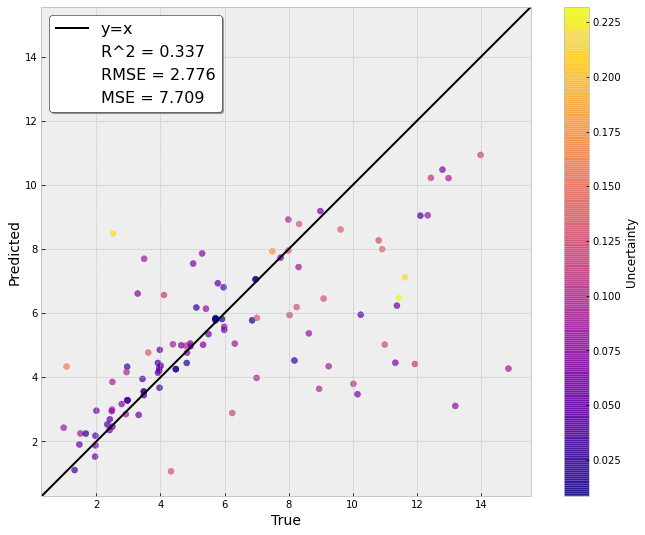

In [136]:
pva_graph(predictions, run_name, use_scaled=False)

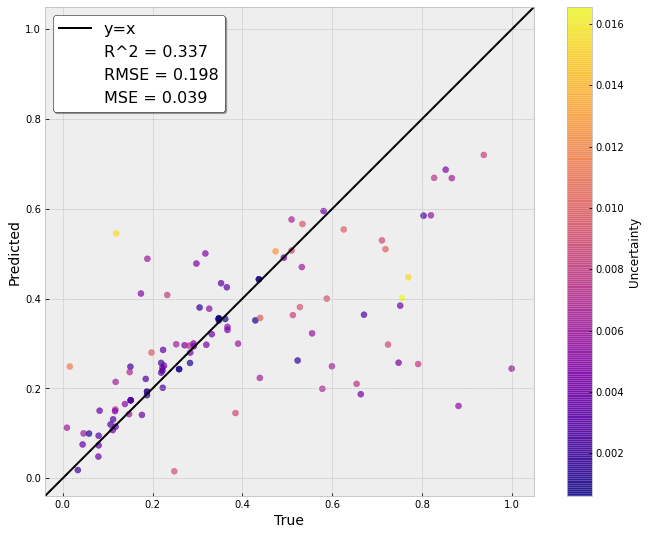

In [137]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

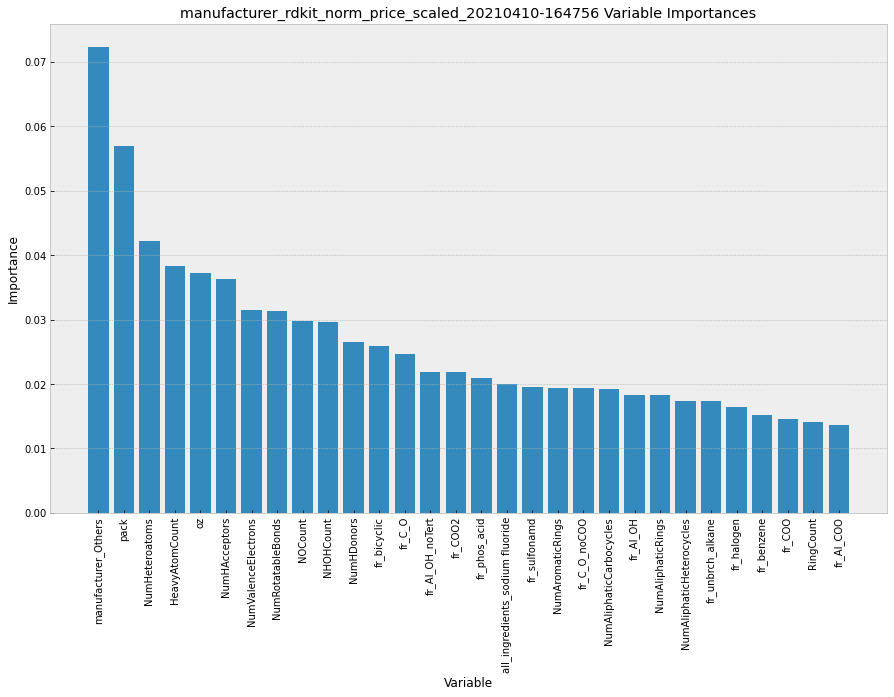

In [138]:
impgraph(estimator,feature_list, run_name)

## Price Manufacturer

In [92]:
df_manufacturer = pd.read_csv("hyper_tune_non_norm_manufacterer.csv") 
df_manufacturer.drop(['Unnamed: 0', 'product_id'], axis=1, inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')
# df_manufacturer.head(5)
df_manufacturer.head(5)
# df_manufacturer

,all_ingredients_ dicalcium phosphate dihydrate,all_ingredients_ glycerin,all_ingredients_ hydrated silica,all_ingredients_ propylene glycol,all_ingredients_ sodium bicarbonate (baking soda),all_ingredients_ sorbitol,all_ingredients_ water,all_ingredients_20,all_ingredients_acacia arabica bark,all_ingredients_acacia arabica bark extract,...,manufacturer_Crest,manufacturer_Hello,manufacturer_Jason,manufacturer_Listerine,manufacturer_Others,manufacturer_Parodontax,manufacturer_Rembrandt,manufacturer_Sensodyne,manufacturer_Tom's,price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5.72
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.97
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5.72
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.90
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.66


### Non Scaled

In [93]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer)


Total Feature Shape: (540, 699)
Total Target Shape (540,)

Training Features Shape: (432, 699)
Training Target Shape: (432,)

Test Features Shape: (108, 699)
Test Target Shape: (108,)



In [94]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [95]:
estimator = get_regressor('gdb', given_param=params)

In [96]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:00<00:03,  1.14it/s]
Model Replication███████████████▌                                      | 2/5 [00:01<00:02,  1.16it/s]
Model Replication████████████████████████████▍                         | 3/5 [00:02<00:01,  1.16it/s]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:03<00:00,  1.17it/s]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]

Done after 3.0 seconds.


In [97]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_non_norm_price_" + date_string

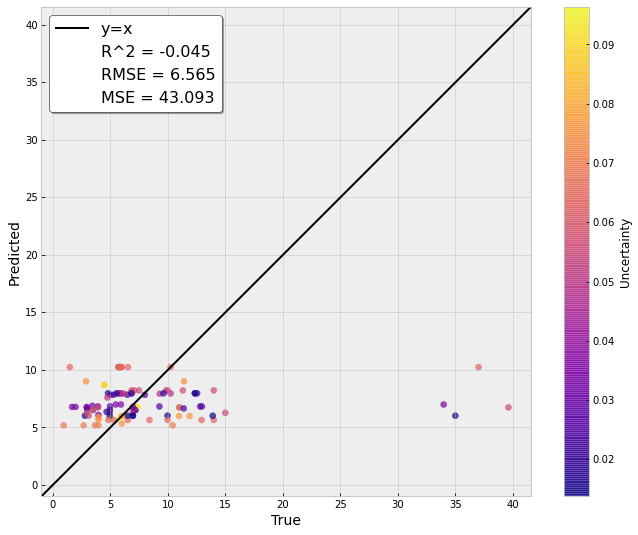

In [98]:
pva_graph(predictions, run_name, use_scaled=False)

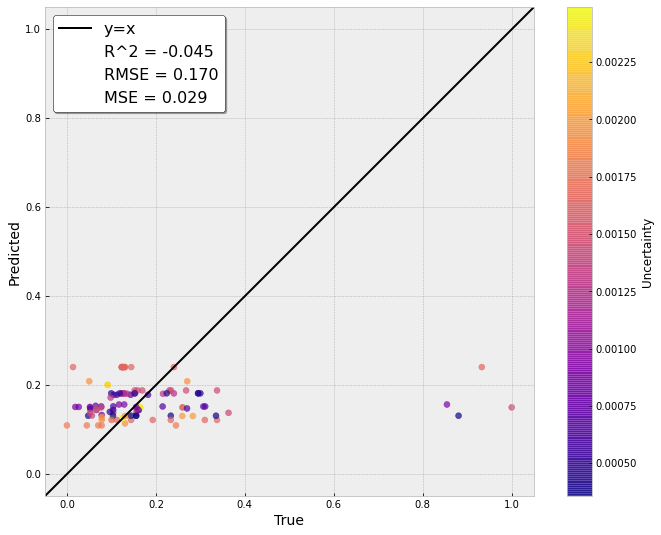

In [99]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

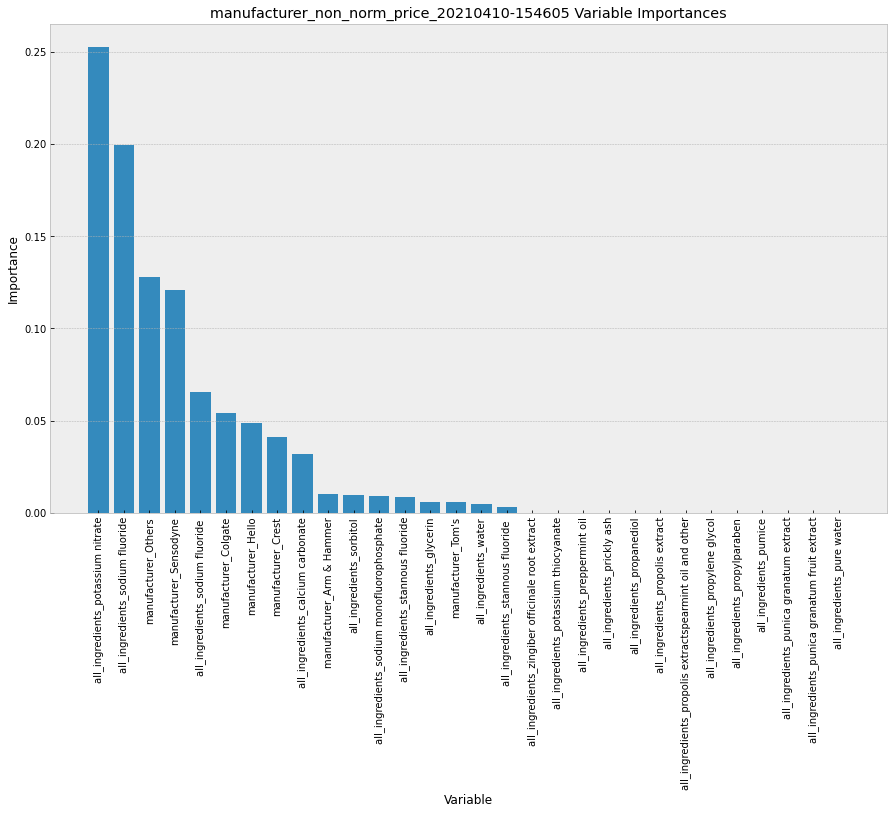

In [100]:
impgraph(estimator,feature_list, run_name)

### Scaled

In [101]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer, scaler='std')


Total Feature Shape: (540, 699)
Total Target Shape (540,)

Training Features Shape: (432, 699)
Training Target Shape: (432,)

Test Features Shape: (108, 699)
Test Target Shape: (108,)



In [102]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)

In [103]:
estimator = get_regressor('gdb', given_param=params)

In [104]:
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:00<00:03,  1.18it/s]
Model Replication███████████████▌                                      | 2/5 [00:01<00:02,  1.20it/s]
Model Replication████████████████████████████▍                         | 3/5 [00:02<00:01,  1.14it/s]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:03<00:00,  1.10it/s]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]

Done after 3.1 seconds.


In [105]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_non_norm_price_scaled" + date_string

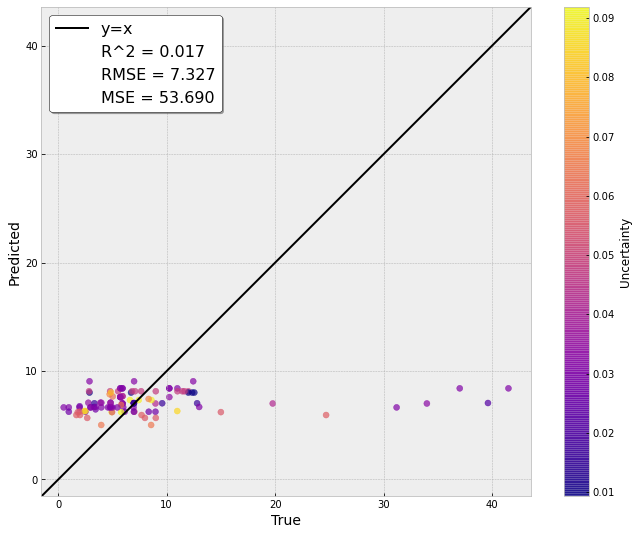

In [106]:
pva_graph(predictions, run_name, use_scaled=False)

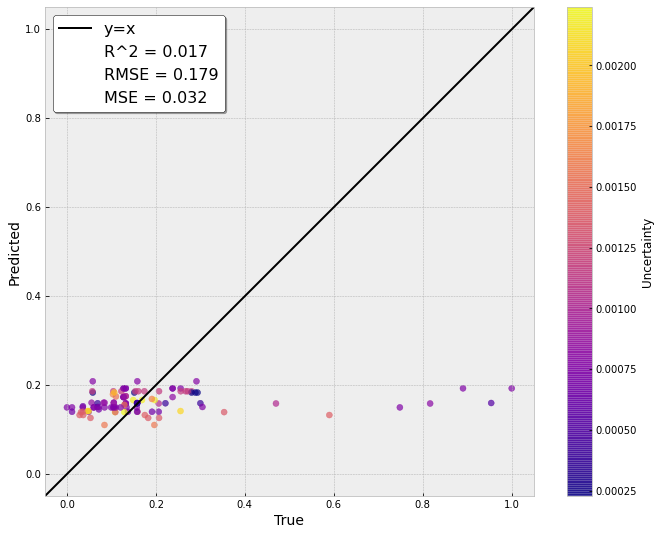

In [107]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

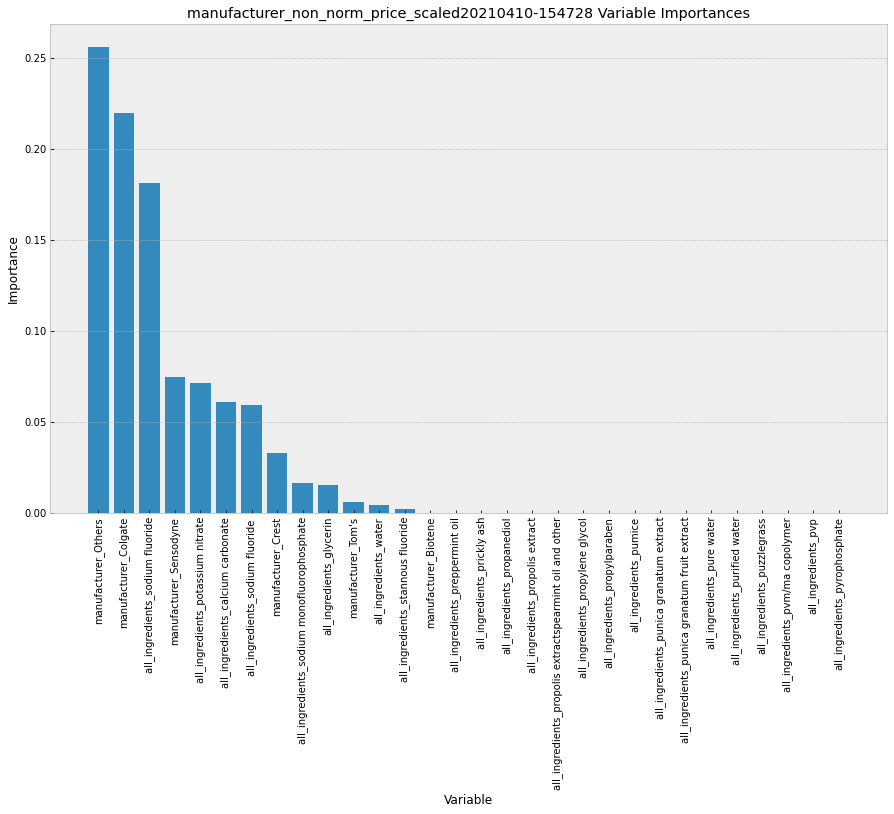

In [108]:
impgraph(estimator,feature_list, run_name)

## Price using RDKIT No Pack, oz

In [114]:
df_manufacturer = pd.read_csv(rdkit)
df_manufacturer.drop(['Unnamed: 0', 'pack', 'oz'], axis=1, inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')
df_manufacturer

,price,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,...,fr_hdrzine,fr_nitro,fr_priamide,fr_imidazole,fr_N_O,fr_imide,fr_sulfone,fr_SH,fr_thiocyan,fr_nitroso
0,6.520,279,40,98,9,9,5,1,6,84,...,0,0,0,0,0,0,0,0,0,0
1,3.960,83,16,36,1,1,1,0,1,30,...,0,0,0,0,0,0,0,0,0,0
2,5.920,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,0,0
3,4.960,285,56,120,12,12,1,0,1,107,...,0,0,0,0,0,0,0,0,0,0
4,5.470,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,3.960,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
586,3.290,73,22,30,0,0,0,0,0,23,...,0,0,0,0,0,0,0,0,0,0
587,15.475,143,23,45,2,3,5,0,5,42,...,0,0,0,0,0,0,0,0,0,0
588,8.990,118,17,46,1,1,1,0,1,37,...,0,0,0,0,0,0,0,0,0,0


In [115]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer, scaler='std')


Total Feature Shape: (590, 80)
Total Target Shape (590,)

Training Features Shape: (472, 80)
Training Target Shape: (472,)

Test Features Shape: (118, 80)
Test Target Shape: (118,)



In [116]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=deltay,fit_params=None)
estimator = get_regressor('gdb', given_param=params)
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:04<00:18,  4.68s/it]
Model Replication███████████████▌                                      | 2/5 [00:09<00:14,  4.79s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:14<00:09,  4.79s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:18<00:04,  4.72s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.74s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.74s/it]

Done after 22.4 seconds.


In [117]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_non_norm_price_rdkit_no_oz_pack" + date_string

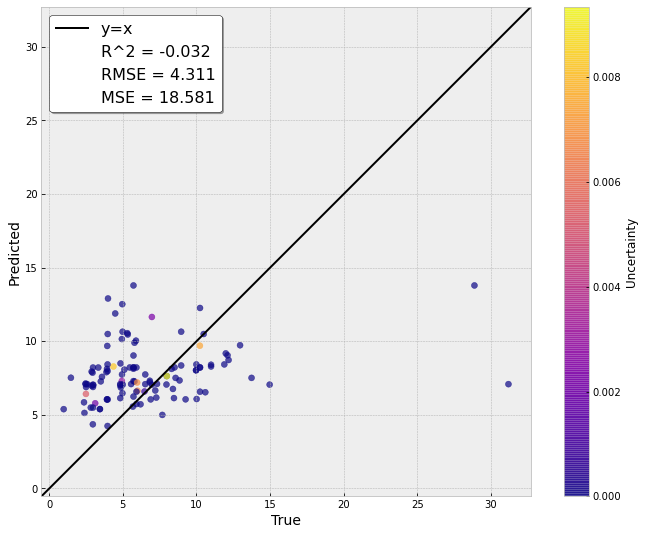

In [118]:
pva_graph(predictions, run_name, use_scaled=False)

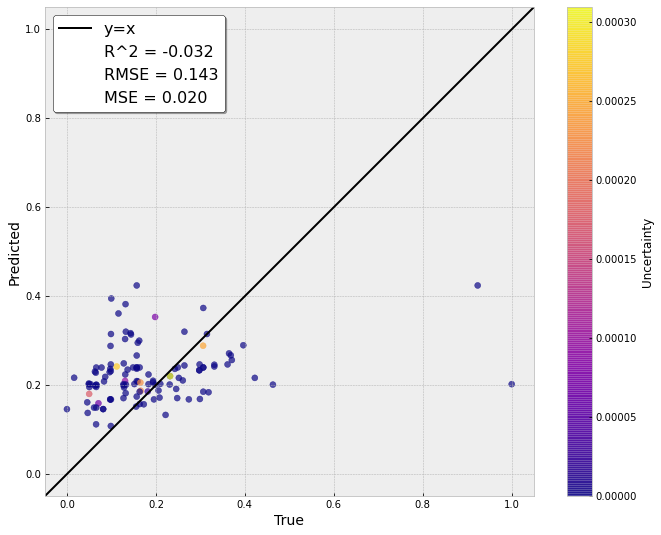

In [119]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

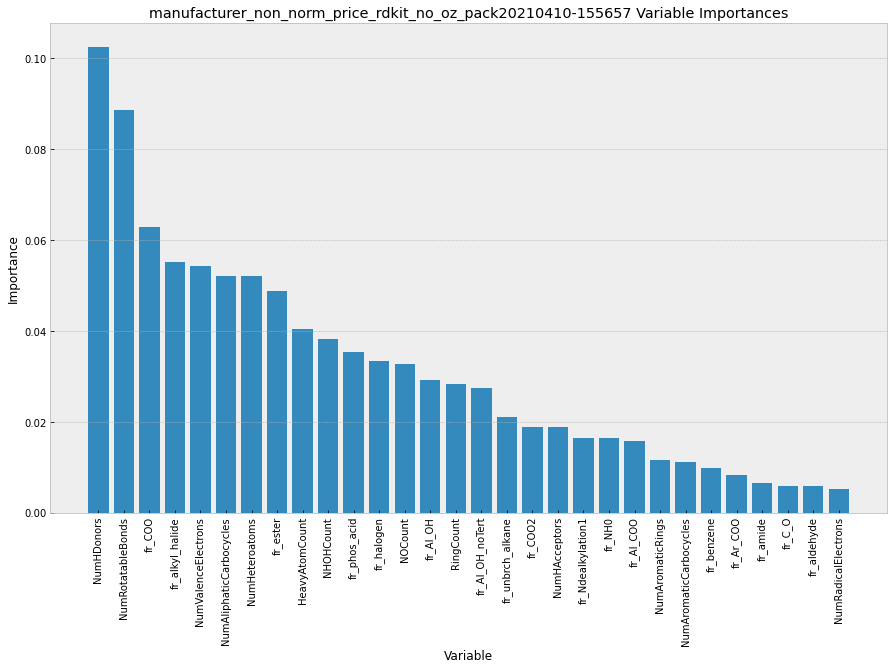

In [120]:
impgraph(estimator,feature_list, run_name)

In [17]:
non_norm_all = pd.read_csv("hyper_tune_non_norm_price_all.csv")

In [47]:
df_manufacturer = pd.read_csv("hyper_tune_non_norm_price_all.csv")
df_rdkit_non_norm = pd.read_csv("hyper_tune_non_norm_manufacterer.csv")
df_manufacturer = df_manufacturer.merge(df_rdkit_non_norm, how='right', on='price')
df_manufacturer.drop_duplicates(subset=['product_id'], inplace=True)
df_manufacturer.drop(['product_id', 'manufacturer', 'Unnamed: 0_x'], inplace=True, axis=1)
df_manufacturer.dropna(inplace=True)
feature_list = list(df_manufacturer.columns)

feature_list.remove('price')
df_manufacturer

,price,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,...,manufacturer_Colgate,manufacturer_Crest,manufacturer_Hello,manufacturer_Jason,manufacturer_Listerine,manufacturer_Others,manufacturer_Parodontax,manufacturer_Rembrandt,manufacturer_Sensodyne,manufacturer_Tom's
0,5.72,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,0
25,1.97,128,15,50,3,3,2,0,2,47,...,0,0,0,0,0,0,0,0,0,0
30,5.72,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,0
55,4.90,77,5,27,1,1,1,0,1,23,...,0,0,0,0,0,0,0,0,0,0
56,3.66,160,27,62,7,7,1,0,1,53,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,5.92,94,7,33,1,1,1,0,1,26,...,0,0,0,0,0,0,0,0,1,0
3395,11.51,7,0,4,0,0,0,0,0,3,...,1,0,0,0,0,0,0,0,0,0
3396,14.97,228,39,90,9,10,2,1,3,81,...,0,1,0,0,0,0,0,0,0,0
3397,2.58,187,34,77,7,7,4,0,4,66,...,0,1,0,0,0,0,0,0,0,0


In [48]:
train_features, test_features, train_target, test_target, val_features, val_target, in_shape = split(df_manufacturer, scaler='std')


Total Feature Shape: (540, 782)
Total Target Shape (540,)

Training Features Shape: (432, 782)
Training Target Shape: (432,)

Test Features Shape: (108, 782)
Test Target Shape: (108,)



In [49]:
params, tune_score = hyperTune(estimator, train_features, train_target, param_grid, opt_iter, n_jobs, cv_folds, scoring,deltay=None,fit_params=None)
estimator = get_regressor('gdb', given_param=params)
predictions, predictions_stats, scaled_predictions, scaled_predictions_stats = train_reg(estimator,train_features, train_target, test_features, test_target,n=5)

Starting model training with 5 replicates.
 

Model Replication
Model Replication                                                              | 0/5 [00:00<?, ?it/s]
Model Replication██▊                                                   | 1/5 [00:14<00:58, 14.75s/it]
Model Replication███████████████▌                                      | 2/5 [00:29<00:43, 14.62s/it]
Model Replication████████████████████████████▍                         | 3/5 [00:44<00:29, 14.92s/it]
Model Replication█████████████████████████████████████████▏            | 4/5 [00:59<00:14, 14.93s/it]
Model Replication██████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.93s/it]
: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.89s/it]

Done after 73.1 seconds.


In [50]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime("%Y%m%d-%H%M%S")  # Get date and time string
run_name = "manufacturer_non_norm_price_rdkit_manu" + date_string

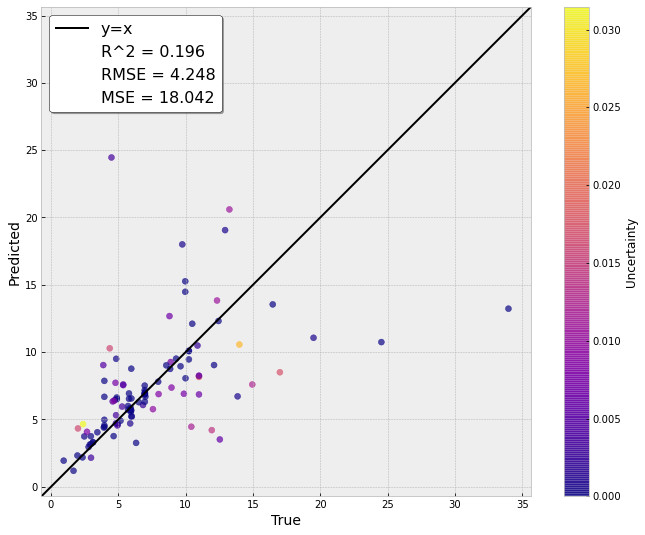

In [51]:
pva_graph(predictions, run_name, use_scaled=False)

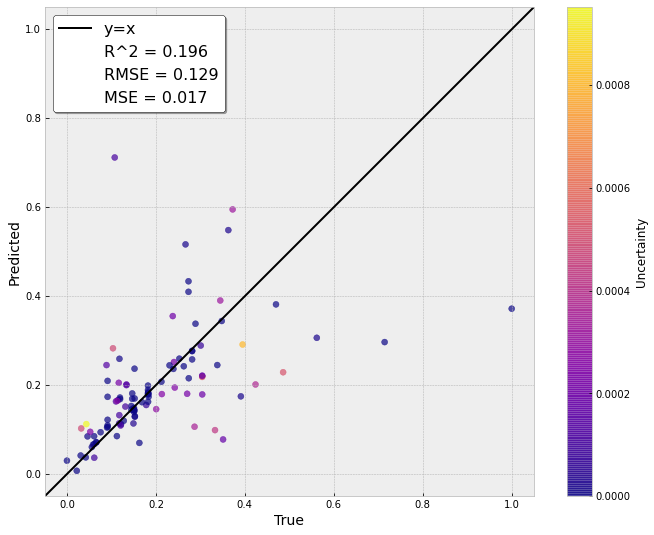

In [52]:
pva_graph(scaled_predictions, run_name, use_scaled=True)

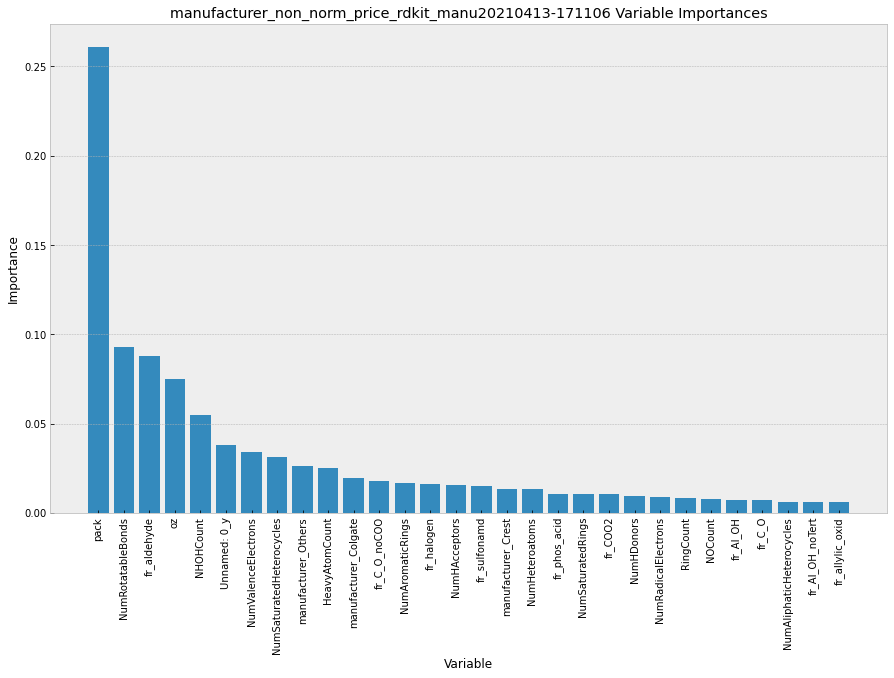

In [53]:
impgraph(estimator,feature_list, run_name)